## LSTM model for generating text

We use keras LSTM cells to build a language model that predicts the next character of text given the input string so far. Use the trained model to make predictions and generate your own favourite author's writing style. The model is trained on the file which is given as input and the weights are saved for further processing.

We show samples generated for the case of Famous Five by Enid Blyton. However, just changing the name of the file and providing the file, you can get it to replicate your own favourite authors.

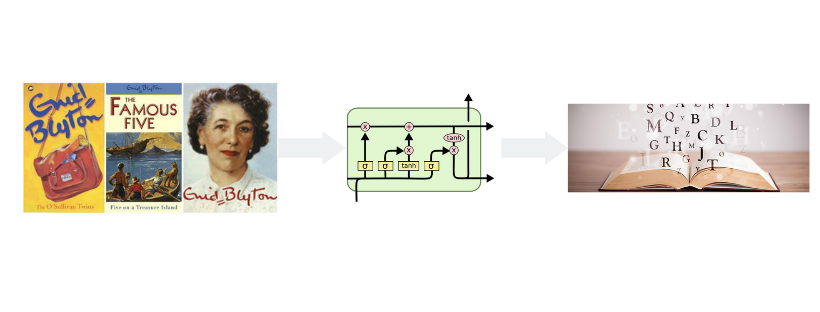
In this example, you train the model on the combined adventures of Famous five, then use the model to compose stuff.
The model works surprisingly well in learning the correct words, rules for capitalizing words, full stops and other punctuations. 

In [1]:
#import stuff

import numpy as np
import tensorflow as tf
import re
import six
import PyPDF2
import pprint

In [2]:
# Gotta print pretty!
pp = pprint.PrettyPrinter(indent=4, depth=4)

#### Reading Input: 

You can change the input path in `input_file` parameter for some different text file.
Also, change the name in `input_file_name` - weights will be stored by this name.

You use snippets from this file as the *training data* for the model. The *target* snippet is offset by one character.

In [3]:
input_file = "input_files/ff.pdf"
input_file_name = 'famous_five'
txt =''

In [4]:
# Function to convert PDF files into text file

def convert_pdf_into_input(text_source):
    txt = ''
    file = open(text_source, 'rb')
    fileReader = PyPDF2.PdfFileReader(file)
    for pageNum in range(fileReader.numPages):
        pageObj = fileReader.getPage(pageNum)
        txt += pageObj.extractText()
    return txt

In [5]:
## If the file format is pdf:
if input_file[-4:]=='.pdf':
    txt = convert_pdf_into_input(input_file)
    
## If the file format is .txt:    
else: 
    with tf.gfile.GFile(input_file, 'r') as f:
        txt = f.read()
txt = re.sub(' +', ' ',txt)

In [6]:
# This is our input text (entire file)
print('Some sample text from the book: ')
print(txt[600:800])
print('\n')
print('Full text is {} characters long'.format(len(txt)))

Some sample text from the book: 
from Daddy - and I only had one from him and Mummy yesterday.' 'I hope it's not bad 
news,' said George, She would not allow anyone to call her 
Georgina, and now even the mistresses called her George


Full text is 217112 characters long


#### Generating training data:

In [7]:
# Function to convert text into integers (also dropping any non-ascii characters)
def transform(txt, pad_to=None):
    output = np.asarray([ord(c) for c in txt if ord(c) < 255], dtype=np.int32)
    if pad_to is not None:
        output = output[:pad_to]
        output = np.concatenate([
            np.zeros([pad_to - len(txt)], dtype=np.int32),
            output,
        ])
    return output

The following function `training_generator` yields (source, target) arrays for training. It first converts the entire text file into integers using `transform` method and removes any non-ascii characters. After that, it randomly chooses `batch_size` number of offsets from the entire text leaving the `seq_len` number of characters from the last. The method then stacks the characters encoded in form of integers, where the current indexed character is the source and the next character is the target for the current character. Thus, we get `batch_size` number of training samples (source and target) of character sequence length as `seq_len`.

In [8]:
def training_generator(input_txt,seq_len=100, batch_size=1024):
  
    tf.logging.info('Input text [%d] %s', len(input_txt), input_txt[:50])
    source = transform(input_txt)
    #print(len(source))
    while True:
        offsets = np.random.randint(0, len(source) - seq_len, batch_size)
        # print(offsets)
    
        # Our model uses sparse crossentropy loss, but Keras requires labels
        # to have the same rank as the input logits.  We add an empty final
        # dimension to account for this.
        yield (
            np.stack([source[idx:idx + seq_len] for idx in offsets]),
            np.expand_dims(
                np.stack([source[idx + 1:idx + seq_len + 1] for idx in offsets]),
                -1),
            )

In [9]:
ip, op = six.next(training_generator(txt,seq_len=5, batch_size=2))
print("Batch of 2 Input sequences of length 5")
pp.pprint(ip)
print("\n")
print("Batch of 2 output sequences of length 5")
pp.pprint(np.transpose(op,[2,0,1]))

# Generates 2 arrays containing 2 lists (input,target) of length 10.  
# General shape: `batch_size X seq_len X 2`

INFO:tensorflow:Input text [217112]  Famous Five 02 Five Go Adventuring Again By Enid 
Batch of 2 Input sequences of length 5
array([[ 32,  70, 105, 118, 101],
       [114, 115,  32, 119,  97]], dtype=int32)


Batch of 2 output sequences of length 5
array([[[ 70, 105, 118, 101,  32],
        [115,  32, 119,  97, 105]]], dtype=int32)


#### Language model: 

Model to learn and predict the next word given the current word. Here, we are using 2 LSTM layers with 512 nodes in each layer. Here, we give `stateful`=True there is need to maintain state between different sequence strings of input as the model needs to learn the overall semantic and synctatic information as the text is connected. <br>
After two LSTM layers, we use `TimeDistributed` to apply a `Dense` layer to each of the timesteps. Since we want output character at each of the input character, we use TimeDistributed layer to wrap a Dense layer at each training and testing input. In this model, the training data generated using `trainig_generator` is used and we take the predicted character as the output at each step. 

In [10]:
EMBEDDING_DIM = 512

In [11]:
def lstm_model(seq_len=100, batch_size=None, stateful=True):
    source = tf.keras.Input(
      name='seed', shape=(seq_len,), batch_size=batch_size, dtype=tf.int32)
    embedding = tf.keras.layers.Embedding(input_dim=256, output_dim=EMBEDDING_DIM)(source)
    lstm_1 = tf.keras.layers.LSTM(EMBEDDING_DIM, stateful=stateful, return_sequences=True)(embedding)
    lstm_2 = tf.keras.layers.LSTM(EMBEDDING_DIM, stateful=stateful, return_sequences=True)(lstm_1)
    predicted_char = tf.keras.layers.TimeDistributed(tf.keras.layers.Dense(256, activation='softmax'))(lstm_2)
    model = tf.keras.Model(inputs=[source], outputs=[predicted_char])

    model.compile(
      optimizer=tf.train.RMSPropOptimizer(learning_rate=0.01),
      loss='sparse_categorical_crossentropy',
      metrics=['sparse_categorical_accuracy'])
    return model

In [12]:
tf.keras.backend.clear_session()

model = lstm_model(seq_len=100, batch_size=128, stateful=True)

Instructions for updating:
Colocations handled automatically by placer.


In [13]:
model.fit_generator(
    training_generator(txt,seq_len=100, batch_size=128),
    steps_per_epoch=100,
    epochs=8
)

INFO:tensorflow:Input text [217112]  Famous Five 02 Five Go Adventuring Again By Enid 
Epoch 1/8
100/100 [==============================] - 29s 293ms/step - loss: 4.3805 - sparse_categorical_accuracy: 0.1644
Epoch 2/8
100/100 [==============================] - 29s 286ms/step - loss: 3.1274 - sparse_categorical_accuracy: 0.1813
Epoch 3/8
100/100 [==============================] - 29s 287ms/step - loss: 1.8010 - sparse_categorical_accuracy: 0.4799
Epoch 4/8
100/100 [==============================] - 29s 287ms/step - loss: 1.0378 - sparse_categorical_accuracy: 0.6853
Epoch 5/8
100/100 [==============================] - 29s 288ms/step - loss: 0.7772 - sparse_categorical_accuracy: 0.7660
Epoch 6/8
100/100 [==============================] - 29s 287ms/step - loss: 0.6426 - sparse_categorical_accuracy: 0.8114
Epoch 7/8
100/100 [==============================] - 29s 287ms/step - loss: 0.5850 - sparse_categorical_accuracy: 0.8310
Epoch 8/8
100/100 [==============================] - 29s 288ms/ste

In [14]:
model_weights_path = 'model_weights/' + input_file_name + '_weights.h5'
model.save_weights(model_weights_path, overwrite=True)

### Make predictions with the model

Use the trained model to make predictions and generate your own novel/play.
Start the model off with a *seed* sentence, then generate 250 characters from it. The model makes five predictions from the initial seed.

Keras requires the batch size be specified ahead of time for stateful models. We use a sequence length of 1, as we will be feeding in one character at a time and predicting the next character.

In [15]:
BATCH_SIZE = 3
PREDICT_LEN = 150

In [16]:
def generate_text(seed_txt):
    prediction_model = lstm_model(seq_len=1, batch_size=BATCH_SIZE, stateful=True)
    prediction_model.load_weights(model_weights_path)
    seed = transform(seed_txt)
    seed = np.repeat(np.expand_dims(seed, 0), BATCH_SIZE, axis=0)
    
    # First, run the seed forward to prime the state of the model starting with reset states
    prediction_model.reset_states()
    for i in range(len(seed_txt) - 1):
        prediction_model.predict(seed[:, i:i + 1])

    # Now we can accumulate predictions
    predictions = [seed[:, -1:]]
    for i in range(PREDICT_LEN):
        last_word = predictions[-1]
        next_probits = prediction_model.predict(last_word)[:, 0, :]

        # sample from our output distribution - to allow variations
        next_idx = [         
                    np.random.choice(256, p=next_probits[i])
                    for i in range(BATCH_SIZE)
        ]
        predictions.append(np.asarray(next_idx, dtype=np.int32))  

    print('Seed text: "' + seed_txt + '"\n')
    # Print out the generated text
    for i in range(BATCH_SIZE):
        print('PREDICTION %d\n' % i)
        p = [predictions[j][i] for j in range(PREDICT_LEN)]
        generated = ''.join([chr(c) for c in p])
        print(seed_txt + generated[1:])
        print()
        assert len(generated) == PREDICT_LEN, 'Generated text too short'

We seed the model with our initial string, copied BATCH_SIZE times, which will generate the number of predictions that we want to observe.

In [17]:
seed_txt = 'The children, lay back in the soft sand and waited. Soon they heard Juli'
# change seed_text according to our input file
generate_text(seed_txt)

Seed text: "The children, lay back in the soft sand and waited. Soon they heard Juli"

PREDICTION 0

The children, lay back in the soft sand and waited. Soon they heard Julian. Hishrent in xd and opened George 
had gone r, and had a vuy fell have stuck. The firelike Latin,' said Julian. 'I don't really want to,' said Geo

PREDICTION 1

The children, lay back in the soft sand and waited. Soon they heard Julian wind
 foot his room where have stuck here for 
th Dick, 'but wentry went on, he was.' 'Ne -this black 
bus home. 
They took her. The little girl f

PREDICTION 2

The children, lay back in the soft sand and waited. Soon they heard Julian. 'No, sir,' said Julian, politely, nol explaile - and we need to say about, or solve things. Where's George?' Nobody answering under his breath. '



In [18]:
seed_txt = 'The children, lay back in the soft sand and waited. Soon they heard Mr. Rola'
# change seed_text according to our input file
generate_text(seed_txt)

Seed text: "The children, lay back in the soft sand and waited. Soon they heard Mr. Rola"

PREDICTION 0

The children, lay back in the soft sand and waited. Soon they heard Mr. Roland's deep Tim darkd and spoken help us, as well as how you know ? We are to be collYou
 suppose all be. Aunte thickly. Julian squeeped cus him. 'Ah, 

PREDICTION 1

The children, lay back in the soft sand and waited. Soon they heard Mr. Roland, excitement of his ligttle morning, shall obs you know those big pages he wring up again. 'Pour of the cotnes is she little rudy across to Kirrin 

PREDICTION 2

The children, lay back in the soft sand and waited. Soon they heard Mr. Roland did me ? Avery dinners. Th
e two artists will be a punishment had not. Seem tou begin lessons again. But I was one here away. Dick put his ar
gain



### Observation

As can be seen above the model is easily able to pick the incomplete character name ("Juli" from Julian or "Mr. Rol" for "Mr. Roland" and is able to complete the text starting with completing the name which is quite extra ordinary ability for a small model which has been trained for ~5 minutes on a piece of text.